In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math as math

In [2]:
# Retrieving Top 100 ETF by AUM Data 
etfdf = pd.read_csv('/Users/dylanzhao/Desktop/Data Science/Data/Portfolio Analysis Data/T100 ETF by AUM.csv', usecols = ['Symbol'])
etfarray = etfdf['Symbol'].to_numpy()

In [3]:
# Retrieving price history from yfinance and formatting into pandas datagrame
rawetfdf = []
for x in etfarray:
    y = yf.Ticker(x)

    x = yf.download(x, start = datetime.now() - relativedelta(years=30), end = datetime.now() - relativedelta(days = 1))

    rawetfdf.append(x['Adj Close'].to_frame().rename(columns = {'Adj Close':y.ticker }))


rawetfdf = pd.concat(rawetfdf,axis = 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
# Get logreturns of top ETFs to use in hypothetical portfolio 
# rawetfdf.dropna(axis = 1, inplace = True)
rawetfdf.drop(columns = rawetfdf.columns[40:],inplace = True)

logreturns = np.log(1 + rawetfdf.pct_change())
logreturns = logreturns.drop(logreturns.index[0])


In [5]:
# Use Monte Carlo simultation to maximize sharpe ratio
# Brute force method, must utilize every stock given 
num_simulations = 500
returns = []
vol = []
sr = []
rw = []

for i in range(num_simulations):
    random_weights = np.random.random(len(logreturns.columns))
    random_weights = random_weights / np.sum(random_weights)
    rw.append(rw)
    
    portreturn = np.sum((logreturns.mean() * random_weights) * 252)
    returns.append(portreturn)

    portrisk = np.sqrt(np.dot(random_weights.T, np.dot(logreturns.cov() * 252, random_weights)))
    vol.append(portrisk)

    sharperatio = portreturn/portrisk
    sr.append(sharperatio)

alldatadf = pd.DataFrame(returns, columns = ['Return'])
alldatadf['Volility'] = vol
alldatadf['Sharpe Ratio'] = sr
alldatadf['Weightings'] = rw
alldatadf.sort_values('Sharpe Ratio', ascending = False, inplace = True)
optimal_weight = rw[alldatadf.index[0]]
print ('Optimal Weight Distribution for Portfolio: ')
print (optimal_weight)
print ('Sharpe Ratio:')
print (alldatadf.iloc[0,2])

Optimal Weight Distribution for Portfolio: 
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [..

Using pypfopt library 

In [6]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [7]:
assetlist = logreturns.columns

er = expected_returns.mean_historical_return(rawetfdf)
risk = risk_models.sample_cov(rawetfdf)

efrontier = EfficientFrontier(er, risk)
weights = efrontier.max_sharpe()

cleanedweights = efrontier.clean_weights()

print (cleanedweights)
efrontier.portfolio_performance(verbose = True)

OrderedDict([('SPY', 0.0), ('IVV', 0.0), ('VOO', 0.16833), ('VTI', 0.0), ('QQQ', 0.0), ('VEA', 0.0), ('VTV', 0.0), ('IEFA', 0.0), ('BND', 0.0), ('AGG', 0.0), ('VUG', 0.0), ('VWO', 0.0), ('IEMG', 0.0), ('IWF', 0.0), ('IJR', 0.0), ('IJH', 0.0), ('VIG', 0.0), ('VXUS', 0.0), ('GLD', 0.14421), ('IWM', 0.0), ('VO', 0.0), ('VGT', 0.0), ('IWD', 0.0), ('BNDX', 0.0), ('EFA', 0.0), ('XLK', 0.0), ('VYM', 0.0), ('SCHD', 0.3896), ('VB', 0.0), ('ITOT', 0.0), ('XLV', 0.0), ('VCIT', 0.0), ('TLT', 0.29787), ('RSP', 0.0), ('BSV', 0.0), ('LQD', 0.0), ('VCSH', 0.0), ('VEU', 0.0), ('XLE', 0.0), ('SCHX', 0.0)])
Expected annual return: 9.8%
Annual volatility: 9.3%
Sharpe Ratio: 0.84


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


(0.09756658604795355, 0.09259323415012696, 0.8377133249519095)

In [8]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

totalport_value = 100000
latest_prices = get_latest_prices(rawetfdf)
weights = cleanedweights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value =  totalport_value)
allocation, leftover = da.lp_portfolio()

print ('Discrete Allocation:')
print (allocation)
print ('Funds Reamining: ')
print (leftover)

Discrete Allocation:
{'VOO': 41, 'GLD': 80, 'SCHD': 523, 'TLT': 314}
Funds Reamining: 
2.9215295168105513


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,Ticker,Number of Shares,Weight
0,VOO,41,0.042797
1,GLD,80,0.083507
2,SCHD,523,0.545929
3,TLT,314,0.327766


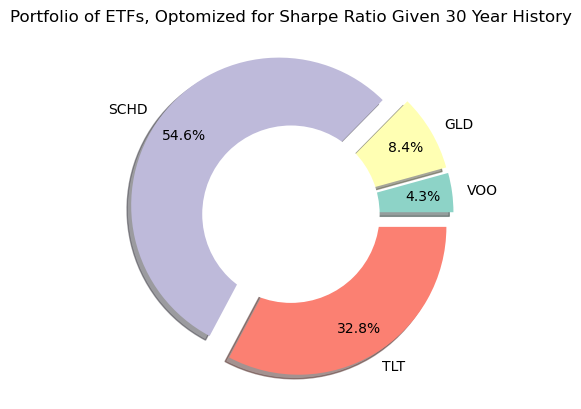

In [9]:
distributions = {'Ticker': allocation.keys(),'Number of Shares': allocation.values()}
ETF_Allocation = pd.DataFrame(data = distributions)
ETF_Allocation['Weight'] = ETF_Allocation['Number of Shares']/(sum(allocation.values()))

expod = []
for i in range (0,len(allocation.keys())):
    expod.append(.1)

plt.pie(
    ETF_Allocation['Number of Shares'],
    labels = ETF_Allocation['Ticker'],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set3'),
    pctdistance= 0.80,
    explode= expod,
    shadow = True,
    )
plt.title('Portfolio of ETFs, Optomized for Sharpe Ratio Given 30 Year History')
plt.show
hole = plt.Circle((0, 0), 0.6, facecolor='white')
plt.gcf().gca().add_artist(hole)
ETF_Allocation